# GLM Tutorial: French Motor Third-Party Liability Claims

This tutorial shows why and how to use Poisson and Gamma GLMs on an insurance claims dataset using scikit-learn, https://github.com/scikit-learn/scikit-learn/pull/9405.

There is a very good tutorial in R for this dataset,
[Case Study: French Motor Third-Party Liability Claims](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3164764) with [R code](https://github.com/JSchelldorfer/ActuarialDataScience/tree/master/1%20-%20French%20Motor%20Third-Party%20Liability%20Claims).

Insurance claims data consist of the number of claims and the total claim amount. Often, the final goal is to predict the expected value, i.e. the mean, of the total claim amount per policy. There are two possiblities to do so:
1. Model total claim amount directly.
2. Model number of claims and claim amount separately with a frequency and a severity model.

We will start with the second option as it shows how to use two different families/distributions within a GLM on a single dataset.

As to why not just use ordinary least squares (OLS):
<br>
If we fit a GLM, the mean-variance relation of its family=distribution is key. Specifying a family is assuming its mean-variance relationship, which tells the GLM, how much a difference in predicted vs observed target values accounts to how much difference in (estimated parameters of) features. For example, the squared error&mdash;Normal distribution&mdash;is quite famous for being very sensitive to outliers, because it attributes much weight to large deviations. Simply put and slightly overstated: With a Normal distribution, a single large claim amount of only one young driver could result in a high prediction for all young drivers.
<br>
Short version: **The world is not Normal!**.

## Table of Contents <a class="anchor" id="toc"></a>
* [1. Load and Prepare Datasets from Openml.org](#1-load)
* [2. Frequency GLM - Poisson Distribution](#2-frequency)
* [3. Severity GLM - Gamma Distribution](#3-severity)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as optimize
import scipy.stats
from dask_ml.preprocessing import Categorizer
from sklearn.model_selection import ShuffleSplit
from quantcore.glm import GeneralizedLinearRegressor
from quantcore.glm import TweedieDistribution

from load_transform import load_transform

## 1. Load and Prepare Datasets from Openml.org <a class="anchor" id="1-load"></a>
[back to table of contents](#toc)

First, we load in our dataset from openML. There are two main datasets. The first is a dataset with insurance policies per row and includes time under insurance cover in years (Exposure), the number of claims (ClaimNb) and several features (Area, VehPower, VehAge, DrivAge, BonusMalus, VehBrand, VehGas, Density, Region). The second lists all claims, one claim per row. It has the the columns policy id (IDpol) and claim amount (ClaimAmount).

For a detailed description of the data, see http://dutangc.free.fr/pub/RRepos/web/CASdatasets-index.html.
For an excellent exploratory data analysis, see the case study paper.

For the simplicity of this tutorial, we do not include the data loading and preparation in this notebook. If you want to run the same code yourself, please see the helper functions here: **TODO – include link once in master**. Below is a summary of the transformations done after loading the raw data: 

* We cut the number of claims to a maximum of 4, as is done in the case study paper (Data error suspected)
* We cut the exposure to a maximum of 1, as is done in the case study paper (Data error suspected).
* We define ClaimAmountCut as the the claim amount cut at 100'000 per single claim (before aggregation per policy). Reason: For the largest claims, extreme value theory might apply. 100'000 is the 0.9984 quantile, claims larger than this limit account for 25% of the overall claim amount. This is a well known phenomenon for third-party liability.
* We aggregate the total claim amounts per policy id and join them to freMTPL2freq.
* We define ClaimNb_pos as the claim number with claim amount greater zero.
* VehPower, VehAge, and DrivAge are clipped and/or digitized into bins so that they can be used as categoricals later on

In [2]:
df = load_transform()
df.describe()

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount,ClaimAmountCut,ClaimNb_pos
count,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,6.780130e+05,678013.000000,678013.000000
mean,0.053179,0.528545,6.255635,1.188850,3.782926,59.761502,1792.422405,8.835998e+01,72.715709,0.038946
std,0.237954,0.364081,1.603689,0.568775,1.304976,15.636658,3958.646564,5.822454e+03,1171.681571,0.205036
min,0.000000,0.002732,4.000000,0.000000,0.000000,50.000000,1.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,0.180000,5.000000,1.000000,3.000000,50.000000,92.000000,0.000000e+00,0.000000,0.000000
50%,0.000000,0.490000,6.000000,1.000000,4.000000,50.000000,393.000000,0.000000e+00,0.000000,0.000000
75%,0.000000,0.990000,7.000000,2.000000,5.000000,64.000000,1658.000000,0.000000e+00,0.000000,0.000000
max,4.000000,1.000000,9.000000,2.000000,6.000000,230.000000,27000.000000,4.075401e+06,115600.000000,4.000000


In [3]:
with pd.option_context('display.max_rows', 10):
    display(df)

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,ClaimAmountCut,ClaimNb_pos
IDpol,,,,,,,,,,,,,,
1,1,0.10000,D,5,0,5,50,B12,Regular,1217,R82,0.0,0.0,0
3,1,0.77000,D,5,0,5,50,B12,Regular,1217,R82,0.0,0.0,0
5,1,0.75000,B,6,1,5,50,B12,Diesel,54,R22,0.0,0.0,0
10,1,0.09000,B,7,0,4,50,B12,Diesel,76,R72,0.0,0.0,0
11,1,0.84000,B,7,0,4,50,B12,Diesel,76,R72,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6114326,0,0.00274,E,4,0,5,50,B12,Regular,3317,R93,0.0,0.0,0
6114327,0,0.00274,E,4,0,4,95,B12,Regular,9850,R11,0.0,0.0,0
6114328,0,0.00274,D,6,1,4,50,B12,Diesel,1323,R82,0.0,0.0,0


## 2. Frequency GLM - Poisson Distribution <a class="anchor" id="2-frequency"></a>
[back to Table of Contents](#toc)
### 2.1 Why Poisson distributions?
We define:
- $z$: number of claims
- $w$: exposure (time in years under risk)
- $y = \frac{z}{w}$: claim frequency per year
- $X$: feature matrix

Note that both the number of claims $z$ and the exposure $w$ are additive. This way, the frequency behaves as expected, if we calculate averages: $\mathrm{mean}(y) = \frac{1}{\sum_i w_i}\sum_i w_i y_i = \frac{\sum_i z_i}{\sum_i w_i}$.

The number of claims $z$ is an integer, $z \in [0, 1, 2, 3, \ldots]$. Theoretically, a policy could have an arbitrarily large number of claims&mdash;very unlikely but possible. The simplest distribution for this range is a Poisson distribution $z \sim Poisson$. Instead of $z$, we will model the frequency $y$, which is still (scaled) Poisson distributed with variance inverse proportional to $w$, cf. [wikipedia:Reproductive_EDM](https://en.wikipedia.org/wiki/Exponential_dispersion_model#Reproductive). A very important property of the Poisson distribution is its mean-variance relation: The variance is proportional to the mean.

We summarize our assumptions for a Poisson-GLM model with log-link:
- target: $y \sim Poisson$
- mean: $\mathrm{E}[y] = \exp(X\beta)$
- variance: $\mathrm{Var}[y] = \frac{1}{w} \mathrm{E}[y]$

Note: We don't need $y$ to be Poisson distributed, for the purpose of estimating the expecation value. Just the mean-variance relationship should be approximately fulfilled: $\mathrm{Var}[y] \propto \frac{1}{w} \mathrm{E}[y]$.

To verify our assumptions, we start by plotting the observed frequencies and a fitted Poisson distributions (Poisson regression with intercept only).

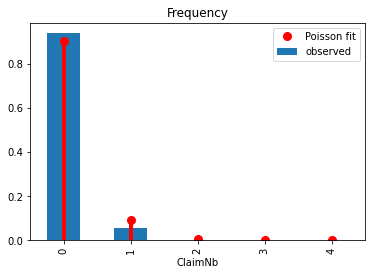

In [4]:
#df['ClaimNb'].plot(kind='hist', density = True)

df_plot = (
    df.loc[:, ['ClaimNb', 'Exposure']]
    .groupby('ClaimNb')
    .sum()
    .assign(Frequency_Observed = lambda x: x.Exposure / df['Exposure'].sum())
)

df_plot['Frequency_Observed'].plot(kind = 'bar', label='observed')

mean = df['ClaimNb'].sum() / df['Exposure'].sum()
x = range(5)
plt.plot(x, scipy.stats.poisson.pmf(x, mean), 'ro', ms=8, mec='r', label='Poisson fit')
plt.vlines(x=x, ymin=0, ymax=scipy.stats.poisson.pmf(x, mean), color='r', lw=4)
plt.xticks(x)
plt.legend()
plt.title("Frequency");

Not too bad, visually.

Next, we want to check the mean-variance relationship of the Poisson distribution: $\mathrm{Var}[Y] = \frac{\mathrm{E}[Y]}{Exposure}$. To to so, we choose the feature `VehPower`, because we hope that the frequency $Y$ depends very much on it. We then plot empirical estimates of $\mathrm{Var}[Y]$ vs $\mathrm{E}[Y]/Exposure$ for every value of `VehPower`.

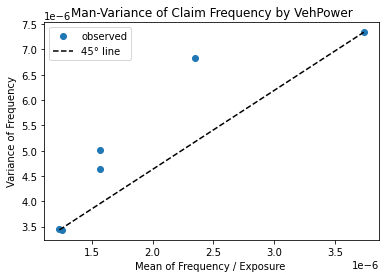

In [5]:
# Check mean-variance relationship for Poisson: Var[Y] = E[Y] / Exposure
# Estimate Var[Y] and E[Y]
# Plot estimates Var[Y] vs E[Y]/Exposure
# Note: We group by VehPower in order to have different E[Y].


def my_agg(x):
    """See https://stackoverflow.com/q/44635626"""
    x_freq = x['Freq']
    x_expos = x['Exposure']
    n = x_freq.shape[0]
    names = {
        'Freq_mean': np.average(x_freq, weights=x_expos),
        'Freq_var': 1/(n-1) * np.sum((x_expos/np.sum(x_expos)) * (x_freq-np.average(x_freq, weights=x_expos))**2),
        'Exposure_sum': x_expos.sum()
    }
    return pd.Series(names, index=['Freq_mean', 'Freq_var', 'Exposure_sum'])

df_plot = (df
           .assign(Freq = lambda x: x['ClaimNb']/x['Exposure'])
           .groupby('VehPower')
           .apply(my_agg)
          )

plt.plot(df_plot['Freq_mean']/df_plot['Exposure_sum'], df_plot['Freq_var'], '.',
         markersize=12, label='observed')

plt.plot([(df_plot['Freq_mean']/df_plot['Exposure_sum']).min(),
          (df_plot['Freq_mean']/df_plot['Exposure_sum']).max()],
         [df_plot['Freq_var'].min(), df_plot['Freq_var'].max()],
         'k--', label='45° line')
plt.xlabel('Mean of Frequency / Exposure ')
plt.ylabel('Variance of Frequency')
plt.legend()
plt.title('Man-Variance of Claim Frequency by VehPower');

This is a strong confirmation for the use of a Poisson when fitting!

Hints:
- If Y were normal distributed, one should see a horizontal line, because for a Normal: Var[Y] ~ constant/Exposure.
- The 45° line is not even necessary, any straight line through the origin would be enough for simple reasons:
    1. A quasi-Poisson distribution has $Var[Y] = \phi * E[Y]/w$ for some $\phi$.
    2. $\phi$ does not influence the estimation/fitting of E[Y] (thanks @[ExponentialDispersionFamily](https://en.wikipedia.org/wiki/Exponential_dispersion_model)).

### 2.2 Frequency GLM with Train and Test Data
From now on, we use claim number with positive claim amount 'ClaimNb_pos' and we devide the dataset into training set and test set with a 9:1 random split.

TODO make note about cross validation

In [6]:
z = df['ClaimNb_pos'].values
weight = df['Exposure'].values
y = z / weight # claims frequency

ss = ShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train, test = next(ss.split(y))

In [7]:
categoricals = ["VehBrand", "VehGas", "Region", "Area", "DrivAge", "VehAge", "VehPower"]
predictors = categoricals + ["BonusMalus", "Density"]
glm_categorizer = Categorizer(columns=categoricals)

In [8]:
glm_categorizer.fit_transform(df[predictors].iloc[train])

,VehBrand,VehGas,Region,Area,DrivAge,VehAge,VehPower,BonusMalus,Density
IDpol,,,,,,,,,
157038,B2,Regular,R24,A,4,2,7,50,14
3034432,B12,Regular,R91,C,3,0,4,100,204
4128717,B13,Diesel,R24,A,4,2,8,50,34
3187436,B1,Diesel,R53,A,5,1,5,50,40
6066277,B12,Regular,R82,E,6,1,9,50,2658
...,...,...,...,...,...,...,...,...,...
2118590,B12,Diesel,R82,D,5,1,9,85,879
3020007,B5,Diesel,R11,D,4,1,9,56,1609
1089081,B5,Regular,R93,E,3,1,8,50,3744


In [9]:
X_train_p = glm_categorizer.fit_transform(df[predictors].iloc[train])
X_test_p = glm_categorizer.fit_transform(df[predictors].iloc[test])
y_train_p, y_test_p = y[train], y[test] 
w_train_p, w_test_p = weight[train], weight[test]
z_train_p, z_test_p = z[train], z[test]

In [10]:
f_glm1 = GeneralizedLinearRegressor(family='poisson', alpha_search=True, l1_ratio=1, fit_intercept=True)

f_glm1.fit(
    X_train_p,
    y_train_p,
    sample_weight=w_train_p
);

pd.DataFrame({'coefficient': np.concatenate(([f_glm1.intercept_], f_glm1.coef_))},
             index=['intercept'] + f_glm1.feature_names_).T

,intercept,VehBrand__B1,VehBrand__B10,VehBrand__B11,VehBrand__B12,VehBrand__B13,VehBrand__B14,VehBrand__B2,VehBrand__B3,VehBrand__B4,...,VehAge__1,VehAge__2,VehPower__4,VehPower__5,VehPower__6,VehPower__7,VehPower__8,VehPower__9,BonusMalus,Density
coefficient,-4.269268,-0.003721,-0.010846,0.138466,-0.259298,0.0,-0.110712,-0.003604,0.044075,0.0,...,0.045494,-0.139428,-0.070054,-0.028142,0.0,0.0,0.016531,0.164711,0.026764,0.000004


In [11]:
PoissonDist = TweedieDistribution(1)
print('training loss f_glm1: {}'.format(
    PoissonDist.deviance(y_train_p, f_glm1.predict(X_train_p), weights=w_train_p)/np.sum(w_train_p)
))

print('test loss f_glm1: {}'.format(
      PoissonDist.deviance(y_test_p, f_glm1.predict(X_test_p), weights=w_test_p)/np.sum(w_test_p)))

training loss f_glm1: 0.45704947333555146
test loss f_glm1: 0.45793061314157685


A GLM with canonical link function (Normal - identity, Poisson - log, Gamma - 1/x, Binomial - logit) with an intercept term has the so called **balance property**. Neglecting small deviations by the opimizer used for fitting, the results fulfil on the training sample:
$$\sum_{i \in training} w_i y_i = \sum_{i \in training} w_i \hat{\mu}_i$$
Summing up the predictions $\hat{\mu}_i$ yields exaclty the observations $y_i$. 

In [12]:
# balance property of GLM with canonical link, like log-link for Poisson:
z_train_p.sum(), (f_glm1.predict(X_train_p) * w_train_p).sum()

(23785, 23785.198509368805)

In [13]:
# for Poisson deviance, note that the following are equivalent (with freq = count/weight)
# dev(observed count, predicted count) ~ dev(observed freq, predicted freq, sample_weight=weight)
print('training loss f_glm1: {}'.format(
    PoissonDist.deviance(y_train_p, f_glm1.predict(X_train_p), weights=w_train_p)/len(train)))

print('training loss f_glm1: {}'.format(
    PoissonDist.deviance(z_train_p, f_glm1.predict(X_train_p) * w_train_p)/len(train)))

print('testing loss f_glm1:  {}'.format(
    PoissonDist.deviance(z_test_p, f_glm1.predict(X_test_p) * w_test_p)/len(test)))

# Compare to test loss of Mean model
print('testing loss Mean:    {}'.format(
    PoissonDist.deviance(z_test_p,
                     np.average(y_train_p, weights=w_train_p)*w_test_p)/len(test)))

training loss f_glm1: 0.24158428861190612
training loss f_glm1: 0.24158428861190612
testing loss f_glm1:  0.24191717633162374
testing loss Mean:    0.25291674783430484


## 3. Severity GLM -  Gamma Distribution <a class="anchor" id="3-severity"></a>
[back to Table of Contents](#toc)

We fit a GLM model for the severity with the same features as the freq model.
The severity $y$ is the average claim size.
We define:
- $z$: total claim amount, single claims cut at 100_000
- $w$: number of claims (with positive claim amount!)
- $y = \frac{z}{w}$: severity

### 3.1 Why Gamma distributions
The severity $y$ is a positive, real number, $y \in (0, \infty)$. Theoretically, especially for liability claims, one could have arbitrary large numbers&mdash;very unlikely but possible. A very simple distribution for this range is an Exponential distribution, or its generalization, a Gamma distribution $y \sim Gamma$. In the insurance industry, it is well known that the severity might be skewed and have heavy tails, i.e. a few very large losses, as does our dataset. That's why we only analyse the claim amount cut at 100'000.

A Gamma distribution has mean-variance relation $\mathrm{Var}[Y] = \frac{\phi}{w} \mathrm{E}[Y]^2$. Note that the dispersion $\phi$ does not influence the estimation of $E[\mu]$.

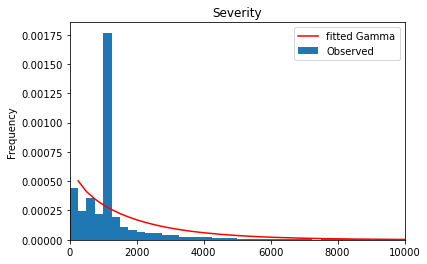

In [14]:
df_plot = (
    df.loc[:, ['ClaimAmountCut', 'ClaimNb_pos']]
    .query('ClaimNb_pos > 0')
    .assign(Severity_Observed = lambda x: x['ClaimAmountCut'] / df['ClaimNb_pos'])
)

df_plot['Severity_Observed'].plot.hist(bins=400, density=True, label='Observed', )

x = np.linspace(0, 1e5, num=400)
plt.plot(x,
         scipy.stats.gamma.pdf(x, *scipy.stats.gamma.fit(df_plot['Severity_Observed'], floc=0)),
         'r-', label='fitted Gamma')
plt.legend()
plt.title("Severity");
plt.xlim(left=0, right = 1e4);
#plt.xticks(x);

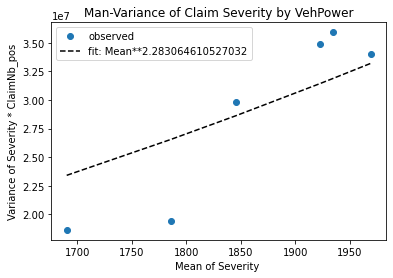

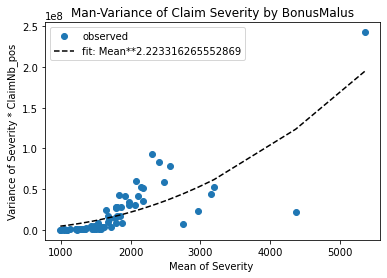

In [15]:
# Check mean-variance relationship for Gamma: Var[Y] = E[Y]^2 / Exposure
# Estimate Var[Y] and E[Y]
# Plot estimates Var[Y] vs E[Y]^s/Exposure
# Note: We group by VehPower and BonusMalus in order to have different E[Y].

def my_agg(x):
    """See https://stackoverflow.com/q/44635626"""
    x_sev = x['Sev']
    x_cnb = x['ClaimNb_pos']
    n = x_sev.shape[0]
    names = {
        'Sev_mean': np.average(x_sev, weights=x_cnb),
        'Sev_var': 1/(n-1) * np.sum((x_cnb/np.sum(x_cnb)) * (x_sev-np.average(x_sev, weights=x_cnb))**2),
        'ClaimNb_pos_sum': x_cnb.sum()
    }
    return pd.Series(names, index=['Sev_mean', 'Sev_var', 'ClaimNb_pos_sum'])

for col in ['VehPower', 'BonusMalus']:
    claims = df.groupby(col)['ClaimNb_pos'].sum()
    df_plot = (df.loc[df[col].isin(claims[claims >= 4].index), :]
               .query('ClaimNb_pos > 0')
               .assign(Sev = lambda x: x['ClaimAmountCut']/x['ClaimNb_pos'])
               .groupby(col)
               .apply(my_agg)
              )

    plt.plot(df_plot['Sev_mean'], df_plot['Sev_var'] * df_plot['ClaimNb_pos_sum'], '.',
             markersize=12, label='observed')

    # fit: mean**p/claims
    p = optimize.curve_fit(lambda x, p: np.power(x, p),
                           df_plot['Sev_mean'].values,
                           df_plot['Sev_var'] * df_plot['ClaimNb_pos_sum'],
                           p0 = [2])[0][0]
    df_fit = pd.DataFrame({'x': df_plot['Sev_mean'],
                           'y': np.power(df_plot['Sev_mean'], p)})
    df_fit = df_fit.sort_values('x')

    plt.plot(df_fit.x, df_fit.y,
             'k--', label='fit: Mean**{}'.format(p))
    plt.xlabel('Mean of Severity ')
    plt.ylabel('Variance of Severity * ClaimNb_pos')
    plt.legend()
    plt.title('Man-Variance of Claim Severity by {}'.format(col))
    plt.show()

This is good empirical confirmation to use the Gamma.

Note: The data seems to be slightly heavier tailed than a Gamma, because estimated p > 2 (it is 2.27 or 2.20). The second plot with BonusMalus might even suggest 2 different regions, on region from 0 to 1'800 and another from 1'800 upwards.

Hint: If Y were normal distributed, one should see a horizontal line, because $Var[Y] \sim constant/Exposure$
       and the fit should give $p \approx 0$.

### 3.2 Severity GLM with Train and Test Data
We fit a GLM model for the severity with the same features as the freq model.

Note:
- We filter out ClaimAmount == 0 as the Gamma distribution as support on $(0, \infty)$ not $[0, \infty)$
- We use ClaimNb_pos as sample weights.
- We use the same split in train and test data such that we can predict the final claim amount on the test set.

In [16]:
idx = df['ClaimAmountCut'].values > 0

z = df['ClaimAmountCut'].values
weight = df['ClaimNb_pos'].values
# y = claims severity
y = np.zeros_like(z)  # zeros will never be used
y[idx] = z[idx] / weight[idx]

# we also need to represent train and test as boolean indices
itrain = np.zeros(y.shape, dtype='bool')
itest = np.zeros(y.shape, dtype='bool')
itrain[train] = True
itest[test] = True
# simplify life
itrain = idx & itrain
itest = idx & itest

In [17]:
X_train_g = glm_categorizer.fit_transform(df[predictors].iloc[itrain])
X_test_g = glm_categorizer.fit_transform(df[predictors].iloc[itest])
y_train_g, y_test_g = y[itrain], y[itest] 
w_train_g, w_test_g = weight[itrain], weight[itest]
z_train_g, z_test_g = z[itrain], z[itest]

In [18]:
s_glm1 = GeneralizedLinearRegressor(family='gamma', alpha_search=True, l1_ratio=1, fit_intercept=True)
s_glm1.fit(X_train_g, y_train_g, sample_weight=weight[itrain])

pd.DataFrame({'coefficient': np.concatenate(([s_glm1.intercept_], s_glm1.coef_))},
             index=['intercept'] + s_glm1.feature_names_).T

,intercept,VehBrand__B1,VehBrand__B10,VehBrand__B11,VehBrand__B12,VehBrand__B13,VehBrand__B14,VehBrand__B2,VehBrand__B3,VehBrand__B4,...,VehAge__1,VehAge__2,VehPower__4,VehPower__5,VehPower__6,VehPower__7,VehPower__8,VehPower__9,BonusMalus,Density
coefficient,7.3389,-0.034591,0.040528,0.13116,0.035838,0.100753,-0.073995,-0.033196,0.0,0.049078,...,0.0,-0.024827,-0.009537,-0.089972,0.071376,0.009361,-0.042491,0.051636,0.002365,-0.000001


In [19]:
GammaDist = TweedieDistribution(2)
print('training loss s_glm1: {}'.format(
    GammaDist.deviance(y[itrain], s_glm1.predict(X_train_g), weights=weight[itrain])/np.sum(weight[itrain])))

print('testing loss s_glm1:  {}'.format(
    GammaDist.deviance(y[itest], s_glm1.predict(X_test_g), weights=weight[itest])/np.sum(weight[itest])))

print('testing loss Mean:    {}'.format(
    GammaDist.deviance(y[itest],
                   np.average(z[itrain], weights=weight[itrain])*np.ones_like(z[itest]),
                   weights=weight[itest])/np.sum(weight[itest])))

# Overfit?

training loss s_glm1: 1.29010461534461
testing loss s_glm1:  1.2975718597070154
testing loss Mean:    1.3115309309577132


We put together the prediction of frequency and severity to get the predictions of the total claim amount per policy.

In [20]:
#Put together freq * sev together
print("Total claim amount on train set, observed = {}, predicted = {}".
     format(df['ClaimAmountCut'].values[train].sum(),
            np.sum(df['Exposure'].values[train] * f_glm1.predict(X_train_p) * s_glm1.predict(X_train_p)))
     )

print("Total claim amount on test set, observed = {}, predicted = {}".
     format(df['ClaimAmountCut'].values[test].sum(),
            np.sum(df['Exposure'].values[test] * f_glm1.predict(X_test_p) * s_glm1.predict(X_test_p)))
     )

Total claim amount on train set, observed = 44594644.68, predicted = 44549152.422470555
Total claim amount on test set, observed = 4707551.37, predicted = 4946960.354743529


In [21]:
#TODO: Evaluate Metric for Claim Amount on test set. Which metric? Tweedie p=1.5? Squared error?

#TODO: QQ-Plot for distributions

## 4. Combined GLM - Tweedie Distribution

In [22]:
t_glm1 = GeneralizedLinearRegressor(family='gamma', alpha_search=True, l1_ratio=1, fit_intercept=True)
t_glm1.fit(X_train_g, y_train_g, sample_weight=weight[itrain])

pd.DataFrame({'coefficient': np.concatenate(([s_glm1.intercept_], s_glm1.coef_))},
             index=['intercept'] + s_glm1.feature_names_).T

,intercept,VehBrand__B1,VehBrand__B10,VehBrand__B11,VehBrand__B12,VehBrand__B13,VehBrand__B14,VehBrand__B2,VehBrand__B3,VehBrand__B4,...,VehAge__1,VehAge__2,VehPower__4,VehPower__5,VehPower__6,VehPower__7,VehPower__8,VehPower__9,BonusMalus,Density
coefficient,7.3389,-0.034591,0.040528,0.13116,0.035838,0.100753,-0.073995,-0.033196,0.0,0.049078,...,0.0,-0.024827,-0.009537,-0.089972,0.071376,0.009361,-0.042491,0.051636,0.002365,-0.000001
